In [1]:
import math
import os

import decoupler as dc
import matplotlib.pyplot as plt
import mofaflex as mf
import mudata as md
import scanpy as sc
import pandas as pd
import mina

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
os.getcwd()

'/home/klaus'

## Importing the data

We get the paths to all the studies we want to evaluate together (here we use 2 studies) and use ```batch_names``` to define the proper study names going forward

In [ ]:
file_names= ["/your/path/here/Chaffin2022_DCM.h5ad", "/your/path/here/Simonson2023_ICM.h5ad"]
batch_names = ["Chaffin", "Simonson"]
chaffin_dat = sc.read_h5ad(filename = file_names[0])
simonson_dat = sc.read_h5ad(filename = file_names[1]) # we define the Anndata objects that we are going to evaluate

Extracting meta data at the sample level is necessary to understand the samples used to build the multicellular map

The input used for ```groupby``` will be used as an anchor for multiple functions, so keep it in mind

In [4]:
metadata_chaffin = mina.up.pp.extract_metadata_from_obs(obs=chaffin_dat.obs, groupby="sample_id", sort=False)
metadata_simonson = mina.up.pp.extract_metadata_from_obs(obs=simonson_dat.obs, groupby="sample_id", sort=False)

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mina/up/pp.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mina/up/pp.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mina/up/pp.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/klaus/miniforge3/envs/MIN

## Pseudobulking - decoupleR

Compute the pseudobulks for each of the studies separately

In [5]:
pdata_chaffin = dc.pp.pseudobulk(chaffin_dat, sample_col="sample_id", groups_col="cell_type")
pdata_simonson = dc.pp.pseudobulk(simonson_dat, sample_col="sample_id", groups_col="cell_type")

In [ ]:
pdata_chaffin.obs = pdata_chaffin.obs.set_index("sample_id", drop=False)
pdata_chaffin.obs.index.name = None

pdata_simonson.obs = pdata_simonson.obs.set_index("sample_id", drop=False)
pdata_simonson.obs.index.name = None

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/anndata/_core/anndata.py:795: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['P1290', 'P1300', 'P1304', 'P1358', 'P1371']

    Inferred to be: categorical

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/anndata/_core/anndata.py:795: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['P1364', 'P1452', 'P1579', 'P1650', 'P1690']

    Inferred to be: categorical



## Separating pseudobulk into cell-types (views)

To get the AnnData dictionary structure we use a custom function for each study, the ```grouping``` parameter is used to determine the "views" (in our case cell types)

In [ ]:
anndata_dict_chaffin = mina.up.pp.split_anndata_by_celltype(pdata=pdata_chaffin, grouping="cell_type")

for _cell_type, adata in anndata_dict_chaffin.items():
    # Sum across observations (rows) for each gene (column)
    if hasattr(adata.X, "toarray"):
        # Sparse matrix case
        total_counts = adata.X.sum(axis=0).A1  # returns 1D array
    else:
        total_counts = adata.X.sum(axis=0)  # numpy array
    # Add to .var
    adata.var["total_counts"] = total_counts

In [ ]:
anndata_dict_simonson = mina.up.pp.split_anndata_by_celltype(pdata=pdata_simonson, grouping="cell_type")

for _cell_type, adata in anndata_dict_simonson.items():
    # Sum across observations (rows) for each gene (column)
    if hasattr(adata.X, "toarray"):
        # Sparse matrix case
        total_counts = adata.X.sum(axis=0).A1  # returns 1D array
    else:
        total_counts = adata.X.sum(axis=0)  # numpy array

    # Add to .var
    adata.var["total_counts"] = total_counts

In [10]:
anndata_dict_chaffin["CM"]

AnnData object with n_obs × n_vars = 42 × 36601
    obs: 'sample_id', 'cell_type', 'disease', 'sex', 'age', 'lvef', 'disease_code', 'heart_failure', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'total_counts'
    layers: 'psbulk_props'

### Filtering

We use the same filtering criteria for both studies, so a for loop is a viable strategy. We are taking parameters from the single study version of the vignette, but for proper use we recommend using the auxiliary pre-filter plotting functions to verify how each filter affects your data.

The normalization of the data and the filtering of highly variable genes is also included in the for loop.

In [11]:
for x, y in [(anndata_dict_chaffin, metadata_chaffin), (anndata_dict_simonson, metadata_simonson)]:
    mina.up.filt.filter_anndata_by_ncells(x, min_cells=20)
    n_samples = len(y.index)
    min_samples = math.trunc(n_samples * 0.4)
    mina.up.filt.filter_views_by_samples(x, min_rows=min_samples)
    mina.up.filt.filter_genes_byexpr(x, min_count=20, min_prop=0.4)
    mina.up.filt.filter_views_by_genes(x, min_genes_per_view=500)
    mina.up.filt.filter_samples_by_coverage(x, threshold=0, min_prop=0.97)
    mina.up.utils.save_raw_counts(x, layer_name="raw_counts")
    mina.up.pp.norm_log(x, target_sum=1e6, exclude_highly_expressed=False, max_value=None, center=True)
    mina.up.filt.filter_hvgs(x)

Raw counts saved in the 'raw_counts' layer for each AnnData object.
Normalization, log-transformation, and scaling complete for all AnnData objects with target_sum = 1000000.0.
Raw counts saved in the 'raw_counts' layer for each AnnData object.
Normalization, log-transformation, and scaling complete for all AnnData objects with target_sum = 1000000.0.


In [18]:
anndata_dict_chaffin["CM"].var

,gene_ids,feature_types,genome,total_counts,mean,std
AL627309.5,ENSG00000241860,Gene Expression,GRCh38-2020-A_premrna,3129.0,1.298643,0.221889
PERM1,ENSG00000187642,Gene Expression,GRCh38-2020-A_premrna,26266.0,3.095805,0.425530
HES4,ENSG00000188290,Gene Expression,GRCh38-2020-A_premrna,15261.0,2.415571,0.522232
C1orf159,ENSG00000131591,Gene Expression,GRCh38-2020-A_premrna,22275.0,3.009636,0.209806
INTS11,ENSG00000127054,Gene Expression,GRCh38-2020-A_premrna,14221.0,2.602519,0.177709
...,...,...,...,...,...,...
MPP1,ENSG00000130830,Gene Expression,GRCh38-2020-A_premrna,7306.0,2.006190,0.247699
BRCC3,ENSG00000185515,Gene Expression,GRCh38-2020-A_premrna,28149.0,3.257683,0.144817
TMLHE-AS1,ENSG00000224533,Gene Expression,GRCh38-2020-A_premrna,71826.0,4.112678,0.458269
SPRY3,ENSG00000168939,Gene Expression,GRCh38-2020-A_premrna,1808.0,0.968724,0.157936


In [19]:
anndata_dict_simonson["CM"].var

,gene_ids,feature_types,genome,total_counts,mean,std
AL627309.5,ENSG00000241860,Gene Expression,GRCh38-2020-A_premrna,344.0,1.450209,0.303991
NOC2L,ENSG00000188976,Gene Expression,GRCh38-2020-A_premrna,1301.0,2.588418,0.262024
ISG15,ENSG00000187608,Gene Expression,GRCh38-2020-A_premrna,496.0,1.636534,0.540443
LINC01786,ENSG00000230415,Gene Expression,GRCh38-2020-A_premrna,309.0,1.343337,0.293430
SSU72,ENSG00000160075,Gene Expression,GRCh38-2020-A_premrna,1464.0,2.741257,0.229071
...,...,...,...,...,...,...
TMEM187,ENSG00000177854,Gene Expression,GRCh38-2020-A_premrna,370.0,1.507788,0.183337
TAZ,ENSG00000102125,Gene Expression,GRCh38-2020-A_premrna,3359.0,3.554622,0.244903
PLXNA3,ENSG00000130827,Gene Expression,GRCh38-2020-A_premrna,252.0,1.301061,0.367942
DKC1,ENSG00000130826,Gene Expression,GRCh38-2020-A_premrna,690.0,2.008504,0.418228


Note to devs: We are using a very shallow way of filtering highly variable genes (seurat version in scanpy). We should let the user use which ever hvg function they want from scanpy

## Modeling

Now that all the single-study level functions have been executed we can merge the AnnData dictionaries, the ```merge_adata_views``` function offers multiple options for joining the views and the variables from each study, for a detailed explanation of how it works we recommend checking the function documentation or calling ```?mina.up.utils.merge_adata_views```

In [20]:
anndata_merged = mina.up.utils.merge_adata_views(
    studies = [anndata_dict_chaffin, anndata_dict_simonson],
    study_names = ["Chaffin", "Simonson"],
    view_mode = "union",
    min_view_studies = 2,
    var_mode = "outer",
    min_var_studies = 2
)

In [21]:
anndata_merged

{'Fib': AnnData object with n_obs × n_vars = 56 × 5700
     obs: 'sample_id', 'cell_type', 'disease', 'sex', 'age', 'disease_code', 'heart_failure', 'psbulk_cells', 'psbulk_counts', 'study'
     var: 'gene_ids', 'feature_types', 'genome', 'total_counts', 'mean', 'std'
     layers: 'psbulk_props', 'raw_counts',
 'Myeloid': AnnData object with n_obs × n_vars = 56 × 3866
     obs: 'sample_id', 'cell_type', 'disease', 'sex', 'age', 'disease_code', 'heart_failure', 'psbulk_cells', 'psbulk_counts', 'study'
     var: 'gene_ids', 'feature_types', 'genome', 'total_counts', 'mean', 'std'
     layers: 'psbulk_props', 'raw_counts',
 'PC': AnnData object with n_obs × n_vars = 53 × 3389
     obs: 'sample_id', 'cell_type', 'disease', 'sex', 'age', 'disease_code', 'heart_failure', 'psbulk_cells', 'psbulk_counts', 'study'
     var: 'gene_ids', 'feature_types', 'genome', 'total_counts', 'mean', 'std'
     layers: 'psbulk_props', 'raw_counts',
 'Lymphoid': AnnData object with n_obs × n_vars = 56 × 1032
 

In [22]:
anndata_merged["CM"].var

,gene_ids,feature_types,genome,total_counts,mean,std
AL627309.5,ENSG00000241860,Gene Expression,GRCh38-2020-A_premrna,3129.0,1.298643,0.221889
PERM1,ENSG00000187642,Gene Expression,GRCh38-2020-A_premrna,26266.0,3.095805,0.425530
HES4,ENSG00000188290,Gene Expression,GRCh38-2020-A_premrna,15261.0,2.415571,0.522232
C1orf159,ENSG00000131591,Gene Expression,GRCh38-2020-A_premrna,22275.0,3.009636,0.209806
INTS11,ENSG00000127054,Gene Expression,GRCh38-2020-A_premrna,14221.0,2.602519,0.177709
...,...,...,...,...,...,...
IDS,ENSG00000010404,Gene Expression,GRCh38-2020-A_premrna,5349.0,4.028746,0.193338
GABRE,ENSG00000102287,Gene Expression,GRCh38-2020-A_premrna,3282.0,3.368449,0.625591
GABRA3,ENSG00000011677,Gene Expression,GRCh38-2020-A_premrna,403.0,1.565735,0.223347
PLXNA3,ENSG00000130827,Gene Expression,GRCh38-2020-A_premrna,252.0,1.301061,0.367942


Don't forget to append the view names to the variables to prevent conflicts with fitting the MOFAFLEX model

In [23]:
mina.up.utils.append_view_to_var(anndata_merged)

In [ ]:
# # Run this to avoid doing all the modeling if you crash
# modelSOFA = mf.MOFAFLEX.load("." + "/data/merged_SOFA" + ".h5mu")
# modelMOFA = mf.MOFAFLEX.load("." + "/data/merged_MOFA" + ".h5mu")

Note to devs: We are still struggling with the repeated names in the model. I have implemented a function that allows you to have unique names, FOR RELIABLE BEHAVIOR always run it

### This is SOFA flavour
Basically you have a semi-supervised approach, where some of your factors are guided by a covariate (sex, age), while the others remain unsupervised

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


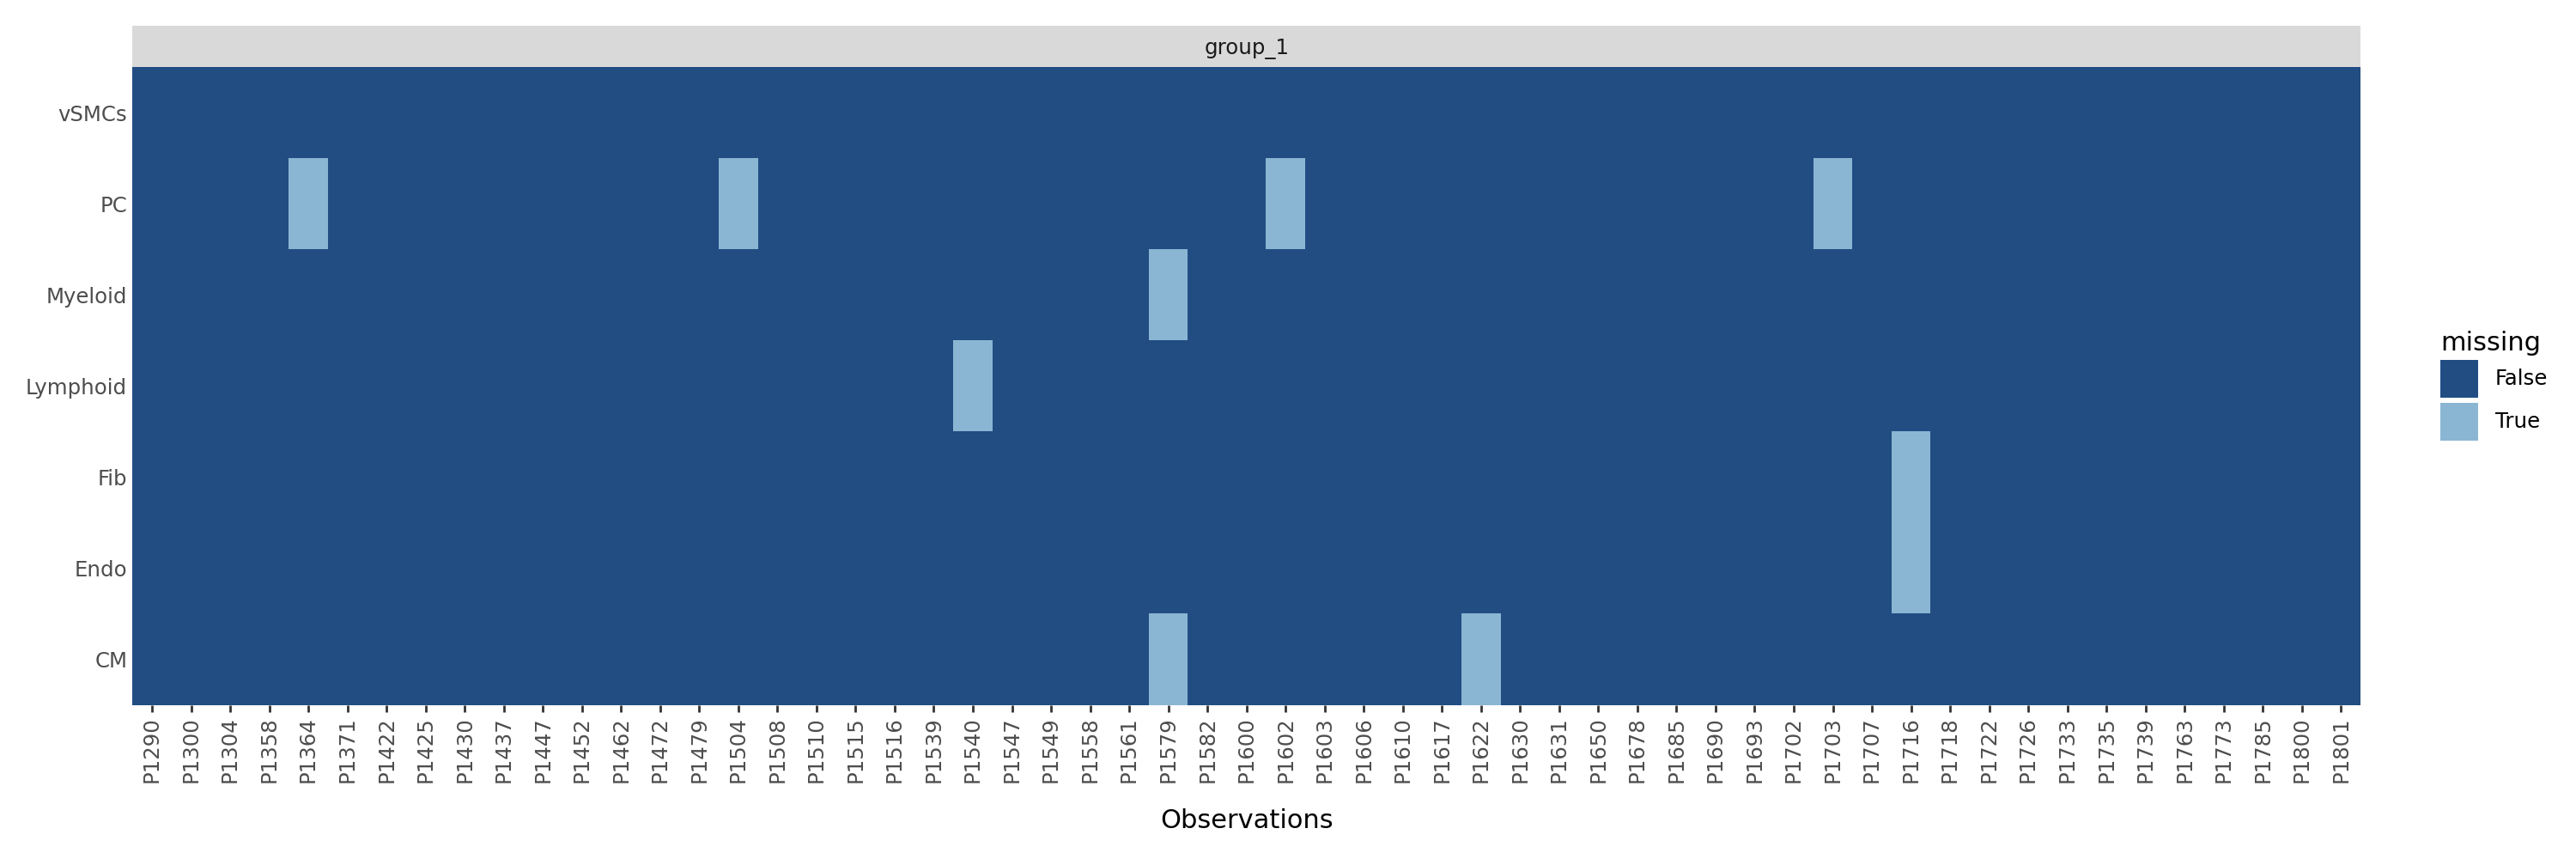

2026-02-20 14:17:07 | [WARNING] Could not import dask. Data arrays may be copied, resulting in high memory usage.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
2026-02-20 14:17:08 | [INFO] Initializing factors using `random` method...
 20%|█▉        | 5929/30000 [

In [ ]:
model_data = md.MuData(anndata_merged)
seed_SOFA_FLEX = 42

# This guides the model
keys_dict = ["heart_failure", "sex", "age"]

likelihood_dict = {"heart_failure": "Bernoulli", "sex": "Bernoulli", "age": "Normal"}
modelSOFA = mf.MOFAFLEX(
    model_data,
    mf.DataOptions(guiding_vars_obs_keys=keys_dict),
    mf.ModelOptions(
        n_factors=7,
        weight_prior="Horseshoe",
        likelihoods="Normal",
        guiding_vars_likelihoods=likelihood_dict,
        annotation_confidence=0.995,
        init_factors="random",
    ),
    mf.TrainingOptions(  # batch_size = 20000,
        max_epochs=30000, device="cpu", seed=seed_SOFA_FLEX, save_path=False, lr=0.01, early_stopper_patience=500
    ),
)

In [29]:
# modelSOFA._save("." + "/data/merged_SOFA" + ".h5mu")

In [33]:
amodelSOFA = mina.down.utils.model_to_anndata(
    anndata_dict=anndata_merged,
    metadata=pd.concat([metadata_chaffin, metadata_simonson]),
    model=modelSOFA,
)

#amodelSOFA.write("./data/output/merged_SOFA.h5ad")

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


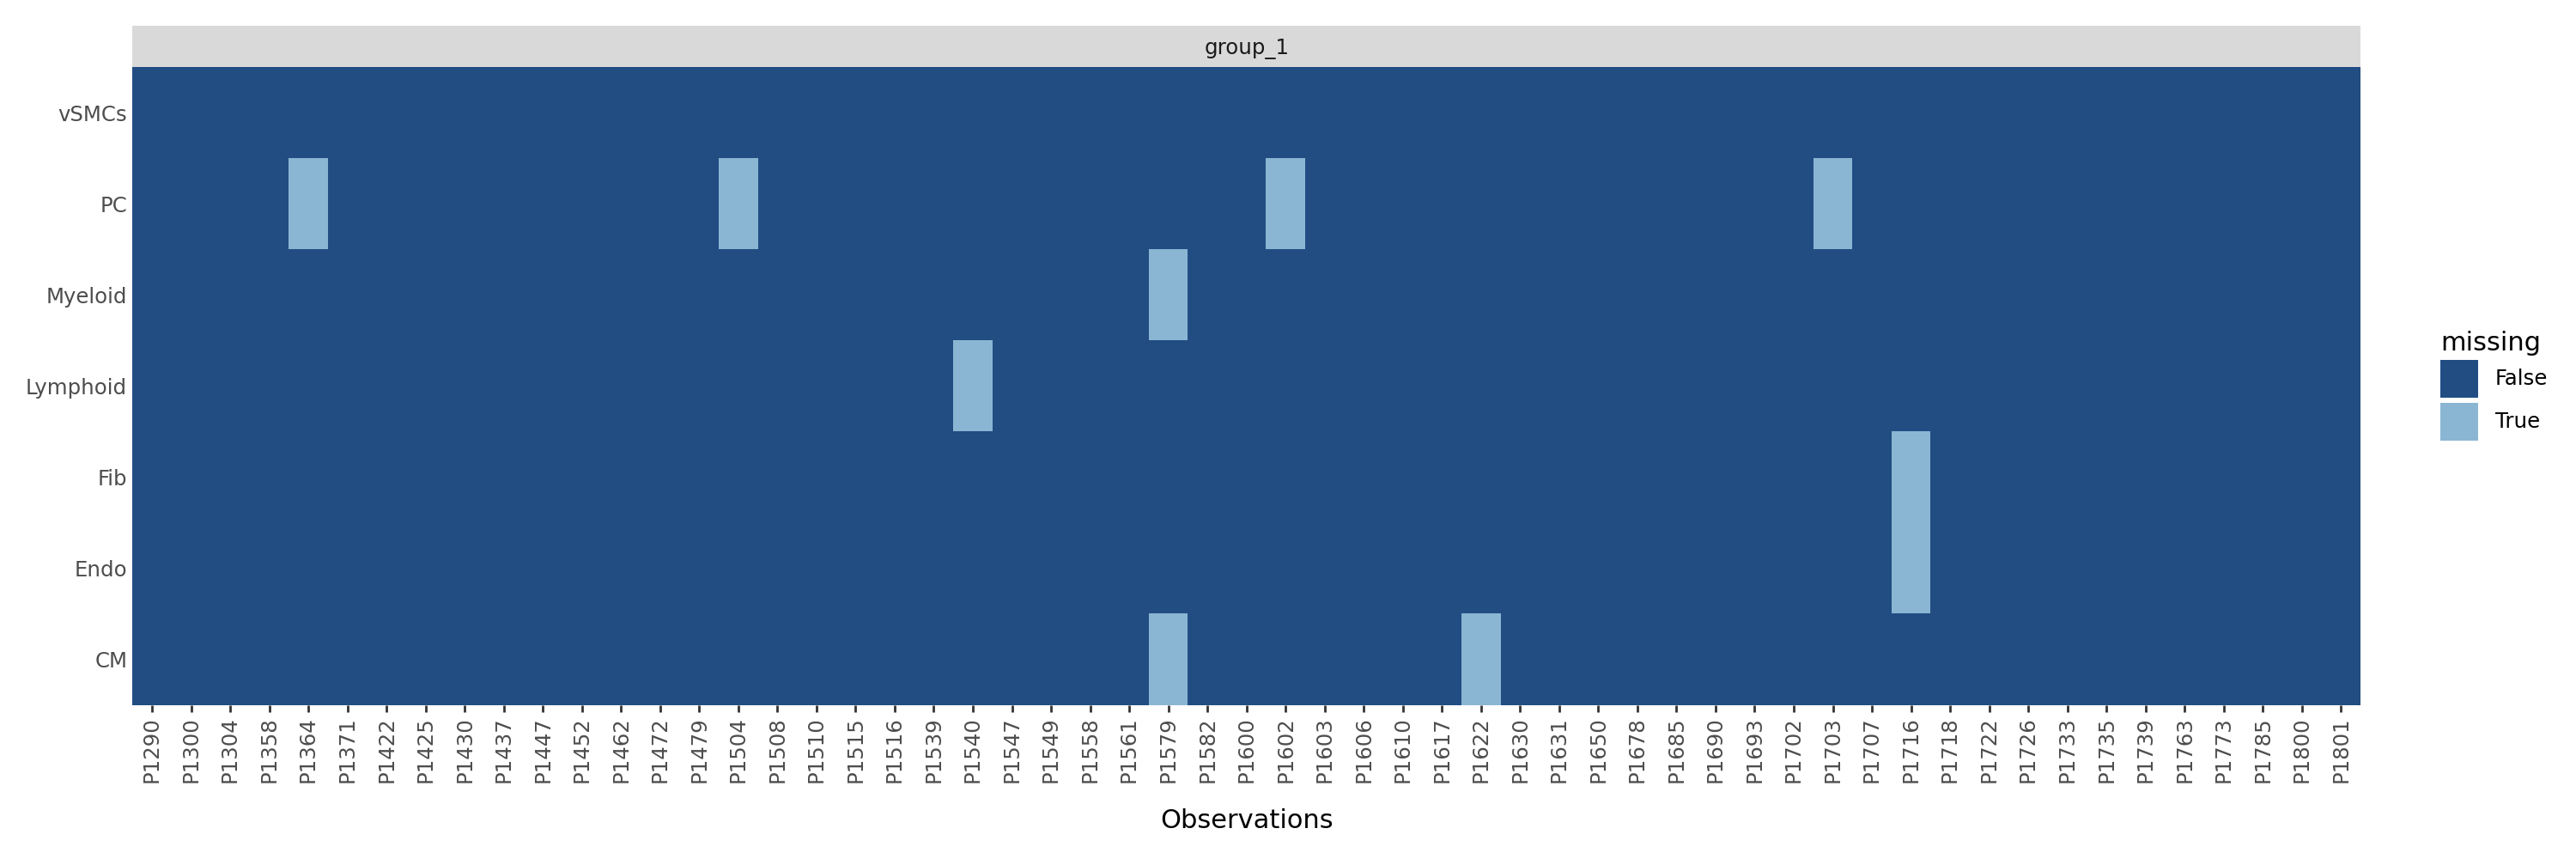

/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/klaus/miniforge3/envs/MINA_stable/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
2026-02-20 14:29:36 | [INFO] Initializing factors using `random` method...
 29%|██▊       | 2866/10000 [06:48<16:56,  7.02epochs/s, Loss=2.75e+4]


In [34]:
mdata = md.MuData(anndata_merged)
modelMOFA = mf.MOFAFLEX(
    mdata,
    mf.ModelOptions(n_factors=15, weight_prior="SnS", likelihoods="Normal"),
    mf.TrainingOptions(seed=42, save_path=False, lr=0.01, early_stopper_patience=500),
)

In [ ]:
# modelMOFA._save("." + "/data/merged_MOFA" + ".h5mu")

In [35]:
amodelMOFA = mina.down.utils.model_to_anndata(
    anndata_dict=anndata_merged,
    metadata=pd.concat([metadata_chaffin, metadata_simonson]),
    model=modelMOFA,
)

# amodelMOFA.write("./data/output/merged_MOFA.h5ad")

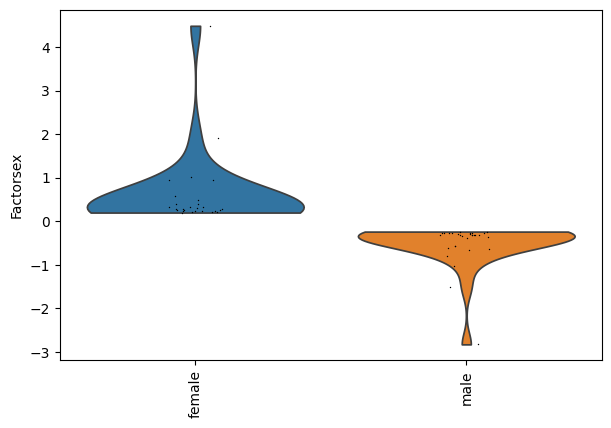

In [38]:
sc.pl.violin(amodelSOFA, "Factorsex", groupby="sex", rotation=90)

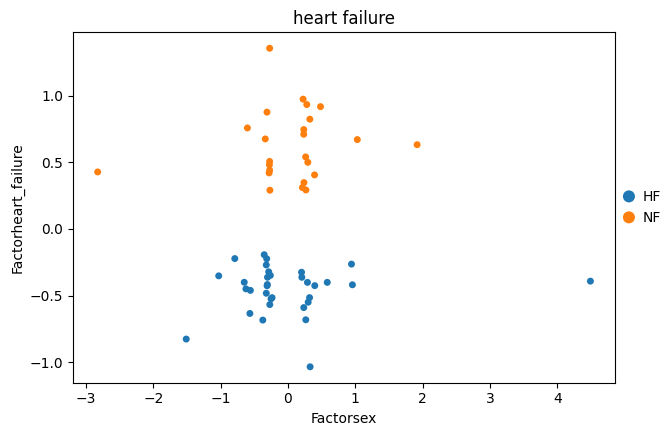

In [39]:
sc.pl.scatter(amodelSOFA, x="Factorsex", y="Factorheart_failure", color="heart_failure", size=100)